In [1]:
import misc
import matplotlib as mpl
import os
import re
import scipy
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from collections import defaultdict
import matplotlib.pyplot as plt
import yaml
import sys
# from venn import venn
from misc import rename_cytokines, rename_bloods
import bcg_utils as utils

%load_ext autoreload
%autoreload 1
%aimport misc
%aimport bcg_utils
%aimport bcg_colors

from bcg_colors import *

In [2]:
_ = utils.setup_plotting(style='ticks', context='notebook', font_scale=1, rc=RC_PAPER)

FIG_SIZE = (2.5, 2.5)
CIRCLE_SIZE = 10
ALPHA = 0.8
CELL_SIZE = 0.125

SAVE_FIG = True
fig_dir = utils.make_dir('results', 'figures', 'Figure1')

# Suppl. Tables

In [3]:
SAVE_TABLES = True
if SAVE_TABLES:
    suppl_tables = misc.get_container_with_tables([IMMUNE_ANALYSIS])

# Figures

In [4]:
df = misc.get_sample_annot()
df = df.loc[~df['DONOR:IC_DATE_REAL'].isnull()]
print('donors', len(set(df['SAMPLE:DONOR'])))
df = df.loc[df['SAMPLE:TISSUE'] == 'PBMC']
print('donors_with_PBMCs', len(set(df['SAMPLE:DONOR'])))
df = df.loc[df['SAMPLE:EXCLUSION'].isnull()]
print('donors_with_PBMCs_without_exclusions', len(set(df['SAMPLE:DONOR'])))

for phenotype in [
    'innate_nonspecific_24h_wo_LAC_IL10_IL1ra',
    'adaptive_MTB_7d'
]:
    for resp_or_non_resp in ['R', 'N']:
        print(resp_or_non_resp, phenotype, len(df.loc[df[f'thm.{phenotype}_V3_FC1.2_responder'] == resp_or_non_resp, 'SAMPLE:DONOR'].unique()))

donors 325
donors_with_PBMCs 325
donors_with_PBMCs_without_exclusions 323
R innate_nonspecific_24h_wo_LAC_IL10_IL1ra 213
N innate_nonspecific_24h_wo_LAC_IL10_IL1ra 78
R adaptive_MTB_7d 217
N adaptive_MTB_7d 74


In [6]:
df = misc.get_sample_annot()
df.index = df.index.str.split('_', expand=True)
df.index.names = ['SAMPLE:DONOR', 'SAMPLE:VISIT', 'SAMPLE:TISSUE']

df = df.loc[~df['DONOR:IC_DATE_REAL'].isnull()]
print('donors', len(set(df['SAMPLE:DONOR'])))

df = df.loc[df['SAMPLE:TISSUE'] == 'PBMC']
print('donors_with_PBMCs', len(set(df['SAMPLE:DONOR'])))

df = df.loc[df['SAMPLE:EXCLUSION'].isnull()]
print('donors_with_PBMCs_without_exclusions', len(set(df['SAMPLE:DONOR'])))

donors_with_good_cytokines = df.loc[~df.loc[:, df.columns.str.contains('^CYTO:.*_good') & ~df.columns.str.contains('lactate')].isnull().all(axis=1), 'SAMPLE:DONOR']
donors_with_CMs = df.loc[~df.loc[:, df.columns.str.contains('^CM:')].isnull().all(axis=1), 'SAMPLE:DONOR']
donors_with_flow_cytometry = df.loc[~df.loc[:, misc.WHOLE_BLOOD].isnull().all(axis=1), 'SAMPLE:DONOR']
donors_with_imputed_pbmc_perc = df.loc[~df.loc[:, misc.BLOOD].isnull().all(axis=1), 'SAMPLE:DONOR']
donors_with_ATAC = df.loc[df['QC:PASS'], 'SAMPLE:DONOR']

donors_with_any_data = pd.concat([donors_with_good_cytokines, donors_with_CMs, donors_with_flow_cytometry, donors_with_ATAC])
donors_with_any_data = donors_with_any_data[~donors_with_any_data.index.duplicated()]

print('')
for name, donors, features in [
    ('donors_with_good_cytokines', donors_with_good_cytokines, df.columns.str.contains('^CYTO:.*_good$')),
    ('donors_with_CMs', donors_with_CMs, df.columns.str.contains('^CM:')),
    ('donors_with_flow_cytometry', donors_with_flow_cytometry, misc.WHOLE_BLOOD),
    ('donors_with_imputed_pbmc_perc', donors_with_imputed_pbmc_perc, misc.BLOOD),
    ('donors_with_ATAC', donors_with_ATAC, None),
    ('donors_with_any_data', donors_with_any_data, None),
]:
    print(name, len(set(donors)))
    display(donors.groupby('SAMPLE:VISIT').count())
    if features is not None:
        for visit in ['V1', 'V2', 'V3']:
            print(visit, 'features:', (~df.loc[donors.loc[donors.index.get_level_values('SAMPLE:VISIT') == visit].index, features].isnull()).sum(axis=1).min())
    print('')

donors 325
donors_with_PBMCs 325
donors_with_PBMCs_without_exclusions 323

donors_with_good_cytokines 317


SAMPLE:VISIT
V1    317
V2    307
V3    292
Name: SAMPLE:DONOR, dtype: int64

V1 features: 18
V2 features: 20
V3 features: 21

donors_with_CMs 322


SAMPLE:VISIT
V1    320
V2    311
V3    300
Name: SAMPLE:DONOR, dtype: int64

V1 features: 73
V2 features: 73
V3 features: 73

donors_with_flow_cytometry 323


SAMPLE:VISIT
V1    323
V2    314
V3    301
Name: SAMPLE:DONOR, dtype: int64

V1 features: 10
V2 features: 10
V3 features: 10

donors_with_imputed_pbmc_perc 323


SAMPLE:VISIT
V1    322
V2    314
V3    301
Name: SAMPLE:DONOR, dtype: int64

V1 features: 11
V2 features: 3
V3 features: 11

donors_with_ATAC 297


SAMPLE:VISIT
V1    273
V2    253
V3    254
Name: SAMPLE:DONOR, dtype: int64


donors_with_any_data 323


SAMPLE:VISIT
V1    323
V2    315
V3    301
Name: SAMPLE:DONOR, dtype: int64

In [7]:
df = misc.get_sample_annot().loc[['{}_V1_PBMC'.format(d) for d in set(donors_with_any_data)]]
print('age:', df['DONOR:AGE'].mean(), df['DONOR:AGE'].std(), df['DONOR:AGE'].min(), df['DONOR:AGE'].max())
print('BMI:', df['DONOR:BMI'].mean(), df['DONOR:BMI'].std())
print('sex:', (df['DONOR:SEX'] == 'F').sum() / len(df))
df.sort_values('DONOR:IC_DATE_REAL')['DONOR:IC_DATE'].iloc[[0, -1]]

age: 26.375877208346097 10.702440818200841 18.204343689466587 71.91934125957413
BMI: 22.50759965855769 2.5557096398505017
sex: 0.5696594427244582


SAMPLE:ID
300BCG006_V1_PBMC    2017-04-10
300BCG325_V1_PBMC    2018-06-14
Name: DONOR:IC_DATE, dtype: object

In [8]:
print('Cytokines measured:', len(set(df.columns[df.columns.str.contains('^CYTO:') & ~df.columns.str.contains('lactate')].str.split('_', expand=True).to_frame()[3])))
print('Cytokines analyzed:', len(set(df.columns[df.columns.str.contains('^CYTO:.*_good$') & ~df.columns.str.contains('lactate')].str.split('_', expand=True).to_frame()[3])))
print('CM measured:', len(set(df.columns[df.columns.str.contains('^CM:')])))

Cytokines measured: 23
Cytokines analyzed: 14
CM measured: 73


In [9]:
df = misc.get_sample_annot()
donors_with_purified_celltypes = set(df.loc[df['SAMPLE:TISSUE'].isin(['monocyte', 'nkcell', 'cd8t']) & (df['SAMPLE:VISIT'] == 'V1'), 'SAMPLE:DONOR'])
assert [d in donors_with_good_cytokines for d in donors_with_purified_celltypes]
print('donors_with_purified_celltypes:', len(donors_with_purified_celltypes))

donors_with_purified_celltypes: 27


In [10]:
df

,CM:ADA_P00813,CM:AXIN1_O15169,CM:Beta.NGF_P01138,CM:CASP.8_Q14790,CM:CCL11_P51671,CM:CCL19_Q99731,CM:CCL20_P78556,CM:CCL23_P55773,CM:CCL25_O15444,CM:CCL28_Q9NRJ3,...,thm.innate_nonspecific_24h_IL10_IL1ra_V3,thm.innate_nonspecific_24h_IL10_IL1ra_V3_FC1.2_responder,thm.innate_nonspecific_24h_V3,thm.innate_nonspecific_24h_V3_FC1.2_responder,thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3,thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_responder,thm.innate_nonspecific_24h_wo_LAC_V3,thm.innate_nonspecific_24h_wo_LAC_V3_FC1.2_responder,thm.lactate_V3,thm.lactate_V3_FC1.2_responder
SAMPLE:ID,,,,,,,,,,,,,,,,,,,,,
300BCG001_V1_PBMC,3.09911,3.98822,1.64720,2.06449,6.17391,9.31515,5.07433,10.48066,4.86754,2.21208,...,0.561377,R,0.453617,R,0.386781,R,0.406181,R,0.291130,R
300BCG001_V2_PBMC,3.11499,4.70302,1.56696,2.31329,6.17622,8.94695,4.62647,10.44789,4.78848,2.09831,...,0.561377,R,0.453617,R,0.386781,R,0.406181,R,0.291130,R
300BCG001_V3_PBMC,3.70142,4.86712,1.73176,3.12509,7.07353,9.52365,6.53693,10.48950,5.37228,2.64576,...,0.561377,R,0.453617,R,0.386781,R,0.406181,R,0.291130,R
300BCG002_V1_PBMC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.066719,N,0.439877,R,0.485652,R,0.439104,R,-0.024762,N
300BCG002_V2_PBMC,3.61480,4.70202,1.22369,2.25026,6.69646,9.41476,5.84963,9.55723,5.47473,2.50362,...,0.066719,N,0.439877,R,0.485652,R,0.439104,R,-0.024762,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300BCG326_V2_PBMC,3.05807,3.56551,1.46681,1.86850,6.79025,8.92757,5.29226,10.23567,5.53538,1.78166,...,-0.129237,N,0.336680,R,0.326136,R,0.279226,R,0.421029,R
300BCG326_V3_PBMC,3.28802,3.46237,1.66440,1.72233,7.03160,8.98579,5.73522,10.68795,5.81484,2.03236,...,-0.129237,N,0.336680,R,0.326136,R,0.279226,R,0.421029,R
300BCG327_V1_PBMC,3.71550,3.11046,1.33727,1.69849,6.84192,8.39329,3.25665,10.44681,5.46928,1.52504,...,-0.187264,N,0.172813,N,0.164118,N,0.125076,N,0.397831,R


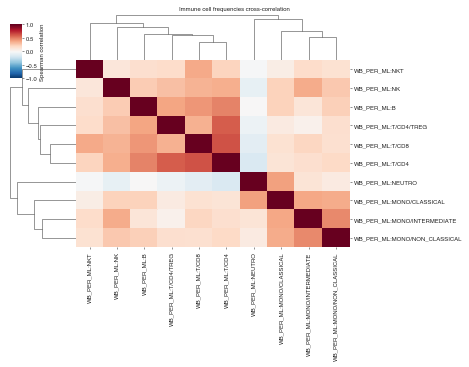

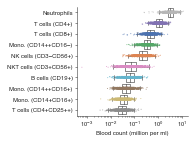

Spearman R  \
Data            Cell type 1     Cell type 2                           
All time points B cells (CD19+) Monocytes (CD14++CD16+)    0.237072   
                                Monocytes (CD14++CD16−)    0.230772   
                                Monocytes (CD14+CD16+)     0.132791   
                                Neutrophils                0.005544   
                                NK cells (CD3−CD56+)       0.251617   

                                                              P-value  
Data            Cell type 1     Cell type 2                            
All time points B cells (CD19+) Monocytes (CD14++CD16+)  1.892304e-13  
                                Monocytes (CD14++CD16−)  8.356135e-13  
                                Monocytes (CD14+CD16+)   4.511085e-05  
                                Neutrophils              8.653400e-01  
                                NK cells (CD3−CD56+)     5.193590e-15

In [11]:
df = misc.get_sample_annot()
df = df.loc[df['SAMPLE:TISSUE'] == 'PBMC']
df.loc[:, df.columns.str.contains('^PBMC_PERC:|^WB_PERC:')] /= 100
WB_CELLTYPES = [
    'WB_PER_ML:MONO/CLASSICAL',
    'WB_PER_ML:MONO/INTERMEDIATE',
    'WB_PER_ML:MONO/NON_CLASSICAL',
    'WB_PER_ML:T/CD8',
    'WB_PER_ML:T/CD4',
    'WB_PER_ML:T/CD4/TREG',
    'WB_PER_ML:B',
    'WB_PER_ML:NK',
    'WB_PER_ML:NKT',
    'WB_PER_ML:NEUTRO'
]
df = df[WB_CELLTYPES]
cg, corr_df, pval_df, padj_df = utils.corr_heatmap_with_pvals(
        df, corr_method='spearman', padj_method='fdr_bh', pval_asterisks=False, annot=None,
        do_not_test_diag=True, cluster=True, vmin=-1, vmax=1, apply_X_clusters_to_Y=True,
        title='Immune cell frequencies cross-correlation', annot_size=9, lw=0, fig_fn=None, title_offset=1,
        cbar_kws=dict(aspect=6, shrink=0.5))
plt.show()

df.columns = rename_bloods(df.columns.str.split(':', expand=True).get_level_values(1),
                           plural=True, drop_cell_suffix=False, short_mono=True, capitalize=True)
df = df[df.median().sort_values(ascending=False).index]
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax = utils.stripplot(data=df, orient='h', s=1, alpha=ALPHA, palette=[LIGHT_GRAY, PURPLE, BLUE, GREEN, ORANGE, PINK, CYAN, BROWN, YELLOW, GRAY], random_state=misc.RANDOM_STATE)
ax = sns.boxplot(data=df, orient='h', fliersize=0, color='gray', whis=[1, 99])
plt.setp(ax.artists, edgecolor='k', facecolor='w', lw=0.5)
plt.setp(ax.lines, color='k', lw=0.5)
ax.set_xscale('log')
ax.set_xlabel('Blood count (million per ml)')
sns.despine()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'fig1_blood_counts.distribution.svg'))
plt.show()

if SAVE_TABLES:
    suppl_df = misc.suppl_table_immune_corr(corr_df, pval_df, Y_name='WB_PER_ML', suppl_tables=suppl_tables, table_name=IMMUNE_ANALYSIS, fig_n='1B')
    display(suppl_df.head())

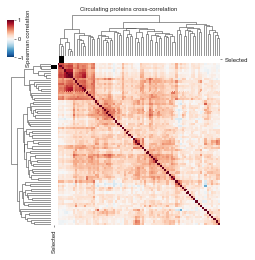

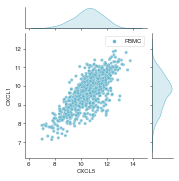

Spearman R  \
Data            Inflammatory marker 1 Inflammatory marker 2               
All time points 4E-BP1                ADA                      0.421425   
                                      Axin-1                   0.747323   
                                      CASP-8                   0.744796   
                                      CCL11                    0.239737   
                                      CCL13                    0.482037   

                                                                   P-value  
Data            Inflammatory marker 1 Inflammatory marker 2                 
All time points 4E-BP1                ADA                     2.224452e-41  
                                      Axin-1                 4.149806e-167  
                                      CASP-8                 2.161952e-165  
                                      CCL11                   1.230503e-13  
                                      CCL13                   2.449710e-55

In [12]:
SELECTED_CM = ['CXCL5', 'CXCL1']

df = misc.get_sample_annot()
df = df.loc[(df['SAMPLE:TISSUE'] == 'PBMC'), df.columns.str.contains('^CM:')]
selected = pd.Series(misc.rename_CMs(df.columns), index=df.columns, name='Selected').isin(SELECTED_CM).map({True: 'black', False: 'white'})
row_colors = pd.concat([selected], axis=1)
cg, corr_df, pval_df, padj_df = utils.corr_heatmap_with_pvals(
    df, corr_method='spearman', padj_method='fdr_bh', pval_asterisks=False, annot=None,
    do_not_test_diag=True, cluster=True, row_colors=row_colors, col_colors=row_colors,
    cell_width=0.048, cell_height=0.048, vmin=-1, vmax=1, apply_X_clusters_to_Y=True,
    title='Circulating proteins cross-correlation', annot_size=9, lw=0, fig_fn=None, title_offset=1,
    xticklabels=0, yticklabels=0, cbar_kws=dict(aspect=6, shrink=0.5))
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'fig1_CM_clusters_V1V2V3.svg'))
    
df.columns = misc.rename_CMs(df.columns)
sns.jointplot(data=df, x=SELECTED_CM[0], y=SELECTED_CM[1],
              palette=[CYAN], hue=['PBMC'] * df.shape[0], height=FIG_SIZE[0], s=CIRCLE_SIZE, alpha=ALPHA)
sns.despine()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'fig1_example_regplot_CM.svg'))
plt.show()

if SAVE_TABLES:
    suppl_df = misc.suppl_table_immune_corr(corr_df, pval_df, Y_name='CM', suppl_tables=suppl_tables, table_name=IMMUNE_ANALYSIS, fig_n='1C')
    display(suppl_df.head())

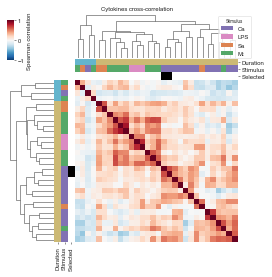

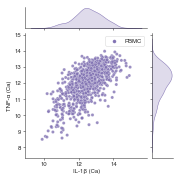

Spearman R       P-value
Data            Cytokine 1     Cytokine 2                                
All time points CCL3 (Ca, 24h) CCL3 (Mt, 24h)      0.177090  7.513056e-06
                               CCL4 (Ca, 24h)      0.504877  2.430560e-55
                               CCL4 (Mt, 24h)      0.280934  8.478223e-15
                               CXCL10 (Ca, 24h)   -0.004679  8.926750e-01
                               CXCL9 (Ca, 24h)    -0.035778  3.009078e-01

In [13]:
SELECTED_CYTO = ['IL-1β (Ca)', 'TNF-α (Ca)']

df = misc.get_sample_annot()
df = df.loc[(df['SAMPLE:TISSUE'] == 'PBMC'), df.columns.str.contains('^CYTO:.*_good')]
duration = misc.rename_cytokines(df.columns, only_time=True)
stimulus = misc.rename_cytokines(df.columns, only_stimulus=True, with_time=False)
duration = pd.Series(duration, index=df.columns, name='Duration').map(DURATION_COLORS)
stimulus = pd.Series(stimulus, index=df.columns, name='Stimulus').map(STIMULUS_COLORS)
selected = pd.Series(misc.rename_cytokines(df.columns), index=df.columns, name='Selected').isin(SELECTED_CYTO).map({True: 'black', False: 'white'})
row_colors = pd.concat([duration, stimulus, selected], axis=1)

cg, corr_df, pval_df, padj_df = utils.corr_heatmap_with_pvals(
    df, corr_method='spearman', padj_method='fdr_bh', pval_asterisks=False, annot=None,
    do_not_test_diag=True, cluster=True, row_colors=row_colors, col_colors=row_colors,
    cell_width=CELL_SIZE, cell_height=CELL_SIZE, vmin=-1, vmax=1, apply_X_clusters_to_Y=True,
    title='Cytokines cross-correlation', annot_size=9, lw=0, fig_fn=None, title_offset=1,
    xticklabels=0, yticklabels=0, cbar_kws=dict(aspect=6, shrink=0.5))
utils.clustermap_legend(ax=cg.ax_col_dendrogram, color_codes=STIMULUS_COLORS, bbox_to_anchor=(1.1, 1), title='Stimulus')
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'fig1_cyto_clusters_V1V2V3.svg'))
    
df.columns = misc.rename_cytokines(df.columns)
g = sns.jointplot(data=df, x=SELECTED_CYTO[0], y=SELECTED_CYTO[1],
                  palette=[PURPLE], hue=['PBMC'] * df.shape[0], height=FIG_SIZE[0], s=CIRCLE_SIZE, alpha=ALPHA)
sns.despine()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'fig1_example_regplot_cytokine.svg'))
plt.show()

if SAVE_TABLES:
    suppl_df = misc.suppl_table_immune_corr(corr_df, pval_df, Y_name='CYTO', suppl_tables=suppl_tables, table_name=IMMUNE_ANALYSIS, fig_n='1D')
    display(suppl_df.head())

In [14]:
if SAVE_TABLES:
    infos, tables = misc.close_tables_and_save(suppl_tables)
    for table, df in zip(tables, infos):
        print(table)
        display(df)

S02_immune_functions


,Contents
Sheet name,
cellFreq_corr,Pairwise Spearman correlations of frequencies ...
inflaMark_corr,Pairwise Spearman correlations of 73 circulati...
cytokine_corr,Pairwise Spearman correlations of 28 ex vivo c...


In [15]:
misc.fix_font_for_suppl_tables(suppl_tables)